# Метрики качества модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

До сих пор мы оценивали качество классификации, используя
**правильность** (долю правильно классифицированных примеров), и 
качество регрессии, используя **R^2**. Однако это лишь два показателя из 
большого количества возможных метрик, используемых для оценки 
качества контролируемой модели на данном наборе данных. На практике 
эти метрики качества могут не соответствовать вашим задачам и поэтому 
очень важно при отборе моделей и корректировке параметров подобрать
правильную метрику.

#### Знайте конечную цель!

Прежде чем
выбрать показатель качества машинного обучения, вам стоит подумать о 
высокоуровневой цели вашего проекта, которую часто называют **бизнес-метрикой** (business metric).

## Метрики для бинарной классификации

В случае бинарной классификации мы говорим о
положительном (positive) классе и отрицательном (negative) классе, 
подразумевая под положительным классом интересующий нас класс.

#### Типы ошибок
- Пример, неправильно спрогнозированный как положительный, называется ложно
положительным (**false positive**).
- Пример, неправильно спрогнозированный как
отрицательный, называется ложно отрицательным (**false negative**).

В статистике ложно положительный пример также известен как **ошибка I рода**, а ложно отрицательный пример – **ошибка II рода** 

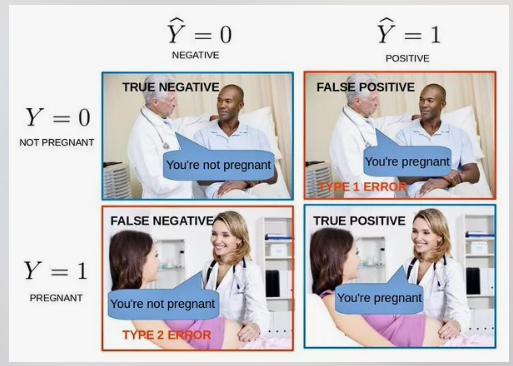

#### Несбалансированные наборы данных

Типы ошибок играют важную роль, когда один из двух классов 
встречается гораздо чаще, чем другой.

Например, при прогнозировании кликов, где 99% данных относится к классу "не кликнул". Модель с высокой правильностью, например, 99%, может быть неинформативной, так как она может просто всегда предсказывать "не кликнул". Поэтому правильность не всегда отражает качество модели в случае дисбаланса классов, и нужно использовать другие метрики для более точной оценки модели.

In [2]:
# задача классификации "девятки" и "не-девятки"

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)
y

array([False, False, False, ..., False,  True, False])

In [3]:
# можем воспользоваться DummyClassifier, который всегда предсказывает мажоритарный класс

from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

In [4]:
np.unique(pred_most_frequent) # все предскказанные предсказались как "не девятка"

array([False])

In [5]:
print(f'Правильность: {dummy_majority.score(X_test, y_test):.2f}') # много ли это?

Правильность: 0.90


Сравним результат с реальной моделью

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Правильность на тестовом наборе: {:.2f}".format(tree.score(X_test, y_test)))

Правильность на тестовом наборе: 0.92


С точки зрения правильности DecisionTreeClassifier оказался чуть 
лучше, чем DummyClassifier, постоянно предсказывающего 
мажоритарный класс. Это может означать, что либо мы неправильно
использовали DecisionTreeClassifier, либо правильность на самом деле
не является в данном случае адекватной метрикой.


Для сравнения давайте оценим качество еще двух классификаторов, 
LogisticRegression и обычный DummyClassifier, который выдает 
случайные прогнозы.

In [7]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("правильность dummy: {:.2f}".format(dummy.score(X_test, y_test)))
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("правильность logreg: {:.2f}".format(logreg.score(X_test, y_test)))

правильность dummy: 0.79
правильность logreg: 0.98


C:\Users\dermi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Проблема здесь заключается в том, что для 
несбалансированных наборов данных правильность не является
адекватной метрикой, позволяющей количественно оценить
прогностическую способность модели

### Матрица ошибок

In [8]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)

In [9]:
confusion

array([[402,   1],
       [  6,  41]], dtype=int64)

Вывод **confusion_matrix** представляет собой массив размером 2x2, где 
строки соответствуют фактическим классам, а столбцы соответствуют 
спрогнозированным классам. В данном случае речь идет о классах «не-девятка» и «девятка». Число в каждой ячейке показывает количество примеров, когда спрогнозированный класс, представленный столбцом, 
совпадает или не совпадает с фактическим классом, представленным 
строкой.

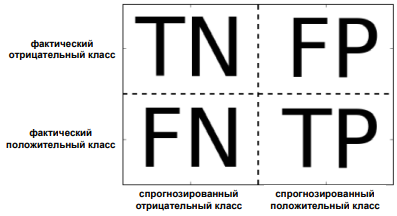

Объявив «девятку» положительным классом, мы можем рассмотреть 
элементы матрицы ошибок в терминах ложно положительных (false
positive) и ложно отрицательных (false negative) примеров, которые мы 
ввели ранее. Для полноты картины мы назовем правильно 
классифицированные положительные примеры истинно
положительными (true positive), а правильно классифицированные 
отрицательные примеры – истинно отрицательными (true negative). Эти 
термины, как правило, записывают в сокращенном виде как **FP, FN, TP и TN**.

In [10]:
# сравнение матрицы ошибок
print("Наиболее часто встречающийся класс:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nДамми-модель:")
print(confusion_matrix(y_test, pred_dummy))
print("\nДерево решений:")
print(confusion_matrix(y_test, pred_tree))
print("\nЛогистическая регрессия")
print(confusion_matrix(y_test, pred_logreg))

Наиболее часто встречающийся класс:
[[403   0]
 [ 47   0]]

Дамми-модель:
[[375  28]
 [ 44   3]]

Дерево решений:
[[390  13]
 [ 24  23]]

Логистическая регрессия
[[402   1]
 [  6  41]]


Из этого сравнения ясно, что лишь дерево решений и 
логистическая регрессия дают разумные результаты, при этом
логистическая регрессия работает лучше дерева во всех отношениях.

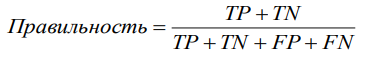

### Точность, полнота, F-мера

**Точность** (precision) показывает, сколько из предсказанных 
положительных примеров оказались действительно положительными.

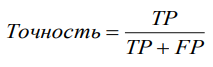

*Точность используется в качестве показателя качества модели, когда 
цель состоит в том, чтобы снизить количество ложно положительных 
примеров. В качестве примера представьте модель, которая дожна 
спрогнозировать, будет ли эффективен новый лекарственный препарат 
при лечении болезни. Клинические испытания, как известно, дороги, и 
фармацевтическая компания хочет провести их лишь в том случае, когда
полностью убедится, что препарат действительно работает. Поэтому
важно минимизировать количество ложно положительных примеров, 
другими словами, необходимо увеличить точность. Точность также 
известна как прогностическая ценность положительного результата
(positive predictive value, PPV).*


**Полнота** (recall) показывает, сколько от общего 
числа фактических положительных примеров было предсказано как 
положительный класс.

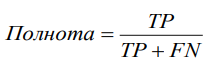

*Полнота используется в качестве показателя качества модели, когда 
нам необходимо определить все положительные примеры, то есть, когда 
важно снизить количество ложно отрицательных примеров. Пример 
диагностики рака является хорошей
иллюстрацией подобной задачи: важно выявить всех больных пациентов, 
при этом, возможно, включив в их число здоровых пациентов.*

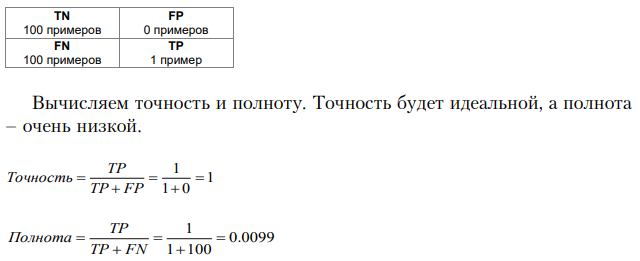

Хотя точность и полнота являются очень важными метриками, сами 
по себе они не дадут вам полной картины. Одним из способов 
подытожить их является **F-мера** (F-measure), которая представляет собой 
гармоническое среднее точности и полноты

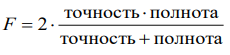

In [11]:
from sklearn.metrics import f1_score

print("f1-мера наибольшая частота: {:.2f}".format(
 f1_score(y_test, pred_most_frequent)))
print("f1-мера дамми: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1-мера дерево: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1-мера логистическая регрессия: {:.2f}".format(
 f1_score(y_test, pred_logreg)))

f1-мера наибольшая частота: 0.00
f1-мера дамми: 0.08
f1-мера дерево: 0.55
f1-мера логистическая регрессия: 0.92


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_most_frequent, target_names=["не-девятка", "девятка"]))

              precision    recall  f1-score   support

  не-девятка       0.90      1.00      0.94       403
     девятка       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\Users\dermi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dermi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dermi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Крайний правый 
столбец – это поддержка (support), которая равна фактическому 
количеству примеров данного класса.

Матрица ошибок и отчет о результатах классификации позволяют 
провести очень детальный анализ полученных прогнозов. Однако сами 
по себе прогнозы лишены большого объема информации, которая 
собрана моделью. Как мы уже говорили в главе 2, большинство 
классификаторов для оценки степени достоверности прогнозов 
позволяют использовать методы **decision_function** или **predict_proba**. 
Получить прогнозы можно, установив для decision_function или 
predict_proba пороговое значение в некоторой фиксированной точке – в 
случае бинарной классификации мы используем 0 для решающей 
функции и 0.5 для метода predict_proba.

In [13]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2],
 random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

In [14]:
# снижаем пороговое значение
# y_pred_lower_threshold = .decision_function(X_test) > -.8 

Выбрать пороговое значение для моделей, поддерживающих метод 
predict_proba, проще, поскольку выводом predict_proba являются 
числа, находящиеся в фиксированном диапазоне от 0 до 1 и 
представляющие собой вероятности. По умолчанию порог 0.5 означает, 
что если модель более чем на 50% «уверена», что данная точка является 
положительным классом, точка будет классифицирована как 
положительный класс.

*Это связано с понятием калибровки
(calibration): калиброванная модель представляет собой модель, которая 
позволяет точно измерить неопределенность оценок.*

### Кривая точности-полноты

Требование, выдвигаемое к качеству модели (например, значение 
полноты должно быть 90%), часто называют рабочей точкой (operating
point). Фиксирование рабочей точки часто бывает полезно в контексте 
бизнеса, чтобы гарантировать определенный уровень качества клиентам 
или другим группам лиц внутри организации.

Как правило, при разработке новой модели нет четкого представления 
о том, что будет рабочей точкой. По этой причине, а также для того, 
чтобы получить более полное представление о решаемой задаче, полезно 
сразу взглянуть на все возможные пороговые значения или все 
возможные соотношения точности и полноты для этих пороговых 
значений. Данную процедуру можно осуществить с помощью 
инструмента, называемого **кривой точности-полноты (precision-recall
curve)**

In [15]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

Функция **precision_recall_curve** возвращает список значений 
точности и полноты для всех возможных пороговых значений (всех 
значений решающей функции) в отсортированном виде, поэтому мы 
можем построить кривую

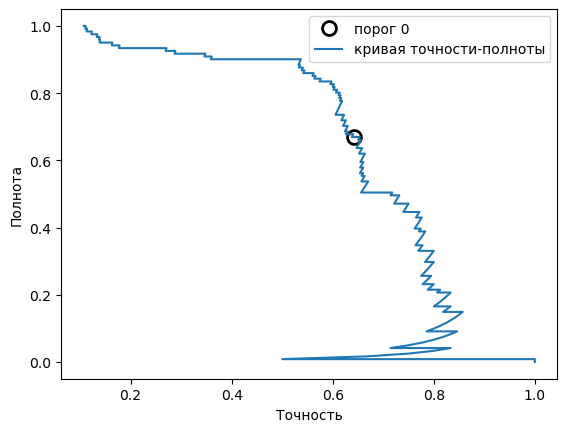

In [17]:
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2],
 random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(
 y_test, svc.decision_function(X_test))
# находим ближайший к нулю порог
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
 label="порог 0", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="кривая точности-полноты")
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")

*Черный кружок отмечает точку, соответствующую порогу 0, пороговому значению по
умолчанию для решающей функции. Данная точка является 
компромиссом, который выбирается при вызове метода predict*

Различные классификаторы могут давать хорошее качество на 
различных участках кривой, то есть в разных рабочих точках. Давайте 
сравним модель SVM с моделью случайного леса, построенной на том же 
наборе данных. RandomForestClassifier вместо decision_function
использует метод predict_proba. Функция precision_recall_curve
ожидает, что в качестве второго аргумента ей будет передана вероятность
положительного класса (класса 1), то есть rf.predict_proba(X_test)[:, 
1].

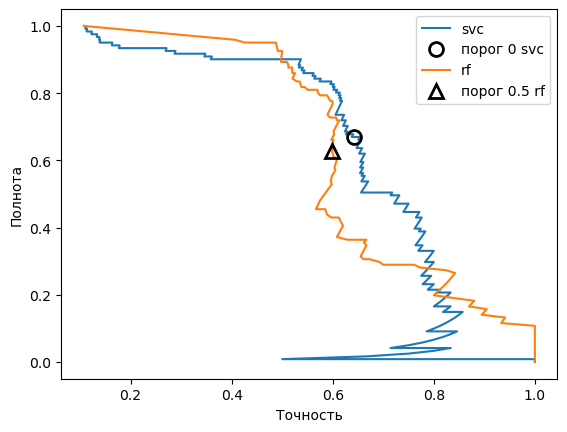

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# в RandomForestClassifier есть predict_proba, но нет decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="порог 0 svc", fillstyle="none", c='k', mew=2)
plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
 markersize=10, label="порог 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")

Из сравнительного графика видно, что случайный лес дает лучшее 
качество, чем в SVM, для крайних пороговых значений, позволяя 
получить очень высокое значение точности или очень высокое значение
полноты. Что касается центральной части кривой (соответствует 
примерной точности=0.7), то SVM работает лучше

In [19]:
print("f1-мера random forest: {:.3f}".format(
 f1_score(y_test, rf.predict(X_test))))
print("f1-мера svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1-мера random forest: 0.610
f1-мера svc: 0.656


Один из
способов подытожить информацию кривой заключается в вычислении
интеграла или площади под кривой точности-полноты, он также известен
как **метод средней точности** (average precision).
Для вычисления средней точности вы можете воспользоваться функцией 
**average_precision_score**. Поскольку нам нужно вычислить кривую 
точности-полноты и рассмотреть несколько пороговых значений, 
функции average_precision_score вместо результата predict нужно 
передать результат decision_function или predict_proba

In [20]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Средняя точность random forest: {:.3f}".format(ap_rf))
print("Средняя точность svc: {:.3f}".format(ap_svc))

Средняя точность random forest: 0.660
Средняя точность svc: 0.666


### Кривая рабочей характеристики приемника ( ROC-кривая )

Как и кривая 
точности-полноты, **ROC-кривая** позволяет рассмотреть все пороговые 
значения для данного классификатора, но вместо точности и полноты 
она показывает **долю ложно положительных примеров** (false positive rate, 
FPR) в сравнении с **долей истинно положительных примеров** (true positive rate). 

*Вспомним, что доля истинно положительных примеров –
это просто еще одно название полноты, тогда как доля ложно 
положительных примеров – это количество ложно положительных 
примеров, поделенное на общее количество отрицательных примеров*

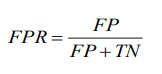

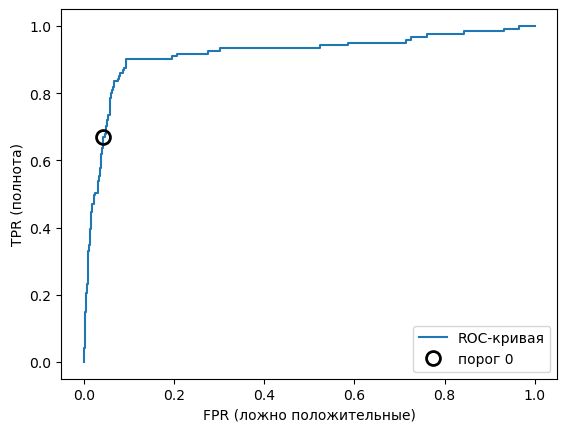

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC-кривая")
plt.xlabel("FPR (ложно положительные)")
plt.ylabel("TPR (полнота)")

# находим пороговое значение, ближайшее к нулю
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="порог 0", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

ROC-кривая - график, отображающий чувствительность и специфичность бинарного классификатора при различных порогах решения. Идеальный классификатор имеет ROC-кривую, проходящую через левый верхний угол (точка (0,1)). Площадь под ROC-кривой (AUC-ROC) является мерой общей производительности, где 1 - идеальный, 0.5 - случайный классификатор. Полезна при работе с несбалансированными данными, позволяя выбрать оптимальный баланс между чувствительностью и специфичностью.

In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC-кривая SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC-кривая RF")
plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
 label="порог 0 SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
 label="порог 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

Как и в случае с кривой точности-полноты, мы хотим подытожить 
информацию ROC-кривой с помощью одного числа, площади под кривой 
(обычно ее просто называют AUC, при этом имейте в виду, что речь идет 
о ROC-кривой). Мы можем вычислить площадь под ROC-кривой с 
помощью функции **roc_auc_score**

In [ ]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC для случайного леса: {:.3f}".format(rf_auc))
print("AUC для SVC: {:.3f}".format(svc_auc))

Сравнив случайный лес и SVM с помощью AUC, мы можем сделать 
вывод, что случайный лес дает чуть более лучшее качество модели, чем 
SVM.

In [ ]:
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(
 digits.data, y, random_state=0)
plt.figure()
for gamma in [1, 0.05, 0.01]:
 svc = SVC(gamma=gamma).fit(X_train, y_train)
 accuracy = svc.score(X_test, y_test)
 auc = roc_auc_score(y_test, svc.decision_function(X_test))
 fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
 print("gamma = {:.2f} правильность = {:.2f} AUC = {:.2f}".format(
 gamma, accuracy, auc))
 plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

При gamma=1.0 значение AUC фактически 
соответствует случайномьу классификатору (случайному результату 
decision_function). При gamma=0.05 качество модели резко повышается
до значения AUC, равного 0.9. И, наконец, при gamma=0.01, мы получим 
идеальное значение AUC, равное 1.0. Это означает, что в соответствии с 
решающей функцией все положительные примеры получают более 
высокий балл, чем все отрицательные примеры. Другими словами, с 
помощью правильного порогового значения эта модель может идеально 
классифицировать данные!

## Метрики для мультиклассовой регрессии

В основном, все 
метрики для мультиклассовой классификации являются производными 
от метрик классификации, но при этом усредняются по всем классам. В
мультиклассовой классификации правильность вновь определяется как 
доля правильно классифицированных примеров. И опять же, когда 
классы не сбалансированы, правильность перестает быть адекватной
метрикой оценки качества.

In [ ]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Правильность: {:.3f}".format(accuracy_score(y_test, pred)))
print("Матрица ошибок:\n{}".format(confusion_matrix(y_test, pred)))


 Матрица ошибок дает нам несколько более подробную 
информацию. Как и в случае бинарной классификации, каждая строка 
соответствует фактической метке класса, а каждый столбец соответствует 
спрогнозированной метке класса.

In [ ]:
print(classification_report(y_test, pred))

Наиболее часто используемой метрикой для оценки качества 
мультиклассовой классификации для несбалансированных наборов
данных является **мультиклассовый вариант f-меры**. 

Идея, лежащая в 
основе мультиклассовой f-меры, заключается в вычислении одной 
бинарной f-меры для каждого класса, интересующий класс становится 
положительным, а все остальные – отрицательными классами. 
Затем эти
f-меры для каждого класса усредняются с использованием одной из 
следующих стратегий:
-  "macro" усреднение вычисляет f-меры для каждого класса и находит 
их невзвешенное среднее. Всем классам, независимо от их размера, 
присваивается одинаковый вес.

- "weighted" усреднение вычисляет f-меры для каждого класса и 
находит их среднее, взвешенное по поддержке (количеству 
фактических примеров для каждого класса). Эта стратегия 
используется в классификационном отчете по умолчанию.

- "micro" усреднение вычисляет общее количество ложно
положительных примеров, ложно отрицательных примеров и истинно 
положительных примеров по всем классам, а затем вычисляет 
точность, полноту и f-меру с помощью этих показателей.

*Если вам необходимо присвоить одинаковый вес каждому примеру, 
рекомендуется использовать микро-усреднение f1-меры, если вам 
необходимо присвоить одинаковый вес каждому классу, рекомендуется 
использовать макро-усреднение f1-меры*

In [ ]:
print("Микро-усредненная f1-мера: {:.3f}".format
 (f1_score(y_test, pred, average="micro")))
print("Mакро-усредненная f1-мера: {:.3f}".format
 (f1_score(y_test, pred, average="macro")))


## Метрики регрессии

Оценить качество регрессии можно таким же способом, которой мы
использовали для классификации, например, сравнив количество 
завышенных и заниженных расчетных значений зависимой переменной. 
Однако в большинстве рассмотренных примеров будет достаточно 
применения **R^2**, который в методе score используется по умолчанию для 
всех моделей регрессии. Иногда бизнес-решения принимаются на основе 
**среднеквадратической ошибки** или **средней абсолютной ошибки**, что 
является стимулом для использования этих метрик при настройке 
моделей.

## Использование метрик оценки для отбора модели (параметров)

Однако часто нам нужно воспользоваться метриками типа AUC для 
отбора модели, выполняемого на основе GridSearchCV или 
cross_val_score. К счастью, scikit-learn предлагает очень простой 
способ решения этой задачи с помощью аргумента **scoring**, который 
можно использовать как в GridSearchCV, так и в cross_val_score. 

*Вы можете просто задать строку с описанием необходимой метрики оценки. 
Допустим, мы хотим оценить качество классификатора SVM при 
решении задачи «девять против остальных» для набора данных digits, 
используя значение AUC. Чтобы поменять метрику оценки с 
правильности, установленной по умолчанию, на AUC, достаточно 
указать "roc_auc" в качестве параметра* **scoring**

In [ ]:
from sklearn.model_selection import cross_val_score

# метрика качества классификационной модели по умолчанию – правильность
print("Метрика качества по умолчанию: {}".format(
 cross_val_score(SVC(), digits.data, digits.target == 9)))
# значение параметра scoring="accuracy" не меняет результатов
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9,
 scoring="accuracy")
print("Метрика качества явно заданная правильность: {}".format(explicit_accuracy))
roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9,
 scoring="roc_auc")
print("Метрика качества AUC: {}".format(roc_auc))

Точно так же мы можем изменить метрику, используемую для отбора 
наилучших параметров в Grid-SearchCV:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
 digits.data, digits.target == 9, random_state=0) 

from sklearn.model_selection import GridSearchCV
# задаем не самую удачную сетку параметров для иллюстрации:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# используем метрику по умолчанию, то есть правильность:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Решетчатый поиск c использованием правильности")
print("Наилучшие параметры:", grid.best_params_)
print("Наилучшее значение перекр проверки (правильность)): {:.3f}".format(grid.best_score_))
print("AUC на тестовом наборе: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Правильность на тестовом наборе: {:.3f}".format(grid.score(X_test, y_test)))

In [ ]:
# используем метрику качества AUC:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nРешетчатый поиск с использованием AUC")
print("Наилучшие параметры:", grid.best_params_)

print("Наилучшее значение перекр проверки (AUC): {:.3f}".format(grid.best_score_))
print("AUC на тестовом наборе: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Правильность на тестовом наборе: {:.3f}".format(grid.score(X_test, y_test)))

Когда использовалась правильность, был выбран параметр 
gamma=0.0001, тогда как при использовании AUC был выбран gamma= 
0.01. В обоих случаях правильность перекрестной проверки 
соответствует правильности на тестовом наборе. Однако использование
AUC позволила найти настройку параметра, оптимальную с точки 
зрения AUC и даже с точки зрения правильности.

Наиболее важными значениями параметра **scoring** для 
классификации являются accuracy (по умолчанию), **roc_auc** для 
площади под ROC-кривой, **average_precision** (площадь под кривой 
точности-полноты), **f1, f1_macro, f1_micro и f1_weighted** для бинарной
f1-меры и различных стратегий усреднения. Для регрессии, наиболее 
часто используемыми значениями являются **r2** для R, 
**mean_squared_error** для среднеквадратической ошибки и 
**mean_absolute_error** для средней абсолютной ошибки. Полный список 
поддерживаемых аргументов вы можете найти, ознакомившись с
документацией или взглянув на словарь SCORERS в модуле
metrics.scorer

In [ ]:
from sklearn.metrics import SCORERS

print("Доступные объекты scorer:\n{}".format(sorted(SCORERS.keys())))

# Вместо вывода

В этой главе есть два довольно важных момента, которые нужно 
повторить, потому что начинающие специалисты, как правило, 
игнорируют их. 

Первый момент связан с перекрестной проверки. 
Перекрестная проверка или использование тестового набора позволяют 
оценить модель машинного обучения с точки зрения того, как она будет 
работать в будущем. Однако, если мы с помощью тестового набора или 
перекрестной проверки осуществляем отбор модели или отбор
параметров модели, мы «растрачиваем» тестовые данные, а 
использование тех же самых данных для оценки работы модели в
будущем приведет к чрезмерно оптимистичным прогнозам. Поэтому нам 
необходимо разбить данные на обучающий набор для построения модели, 
проверочный набор для отбора модели параметров и тестовый набор для 
оценки качества моделей. Вместо одного разбиения мы можем 
использовать разбиения перекрестной проверки. Наиболее часто 
используемым вариантом (как описывалось ранее) является разбиение 
обучение/тест для оценки, а также использование перекрестной 
проверки на обучающем наборе для отбора модели и параметров.

Второй момент связан с важностью метрики качества или функции
оценки, которые используются для отбора модели и оценки модели. 
Теории, связанные с принятием бизнес-решений на основе прогнозов
моделей машинного обучения, в некоторой степени выходят за рамки 
данной книги.
Однако в проектах машинного обучения построение 
модели с высоким значением правильности редко бывает конечной 
целью. Убедитесь в том, что метрика, используемая для оценки и отбора 
модели, является точным приближением решаемой задачи. В реальности
классификационные задачи редко характеризуются 
сбалансированностью классов и зачастую ложно положительные и ложно
отрицательные примеры ведут к совершенно различным последствиям.
Убедитесь в том, что вы правильно интерпретируете эти последствия и 
выберите соответствующую метрику.